<hr>

# Program plots profiles of state variables and process tendencies at various locations and times of ENSO phase

<ul>
<li> Level 1: Mean profiles of states and tendencies during ENSO phase (seasons: monthly means) </li>
<li> Level 2: Time varying profiles during a season or seasonal transtion </li>
<li> Level 3: Statistical reltiosnhips between vertical processes and ENSO/forcing/dynamical strength </li>
</ul>
<hr>

In [1]:

import numpy as np
import matplotlib.pyplot as mp
import xarray as xr
import datetime as dt
#from dateutil.relativedelta import relativedelta


import cartopy.crs as ccrs
import pandas as pd
import metpy as mpy
import dask as ds
xr.__version__

# Dask
from distributed import Client
from ncar_jobqueue import NCARCluster



/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
### To Import My Functions ###
import vert_prof_func as mypy
import vert_prof_case_desc as mycase
import importlib

%load_ext autoreload
%autoreload 2

In [21]:
## DASK WORKERS ##
cluster = NCARCluster()
cluster.scale(10)
client = Client(cluster)
client

/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39771 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rneale/Monsoon/proxy/39771/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rneale/Monsoon/proxy/39771/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.49:33080,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rneale/Monsoon/proxy/39771/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Initial Simulation Information

In [4]:


importlib.reload(mypy) # Required because I am constantly editing scam_func.py
importlib.reload(mycase) # Required because I am constantly editing scam_func.py


''''' Which case to use '''''

case_desc = []

''' ##### REVERT EXPERIMENTS ##### '''

pref_out = 'cam6_revert_test_prog_rep2022'
#case_desc = np.array(['C6','C5','rC5now','rUW','rUWp','rMG1','rC5p','rC5pm','rZMc','rZMp','rpfrac','rCE2i']) ; pref_out = 'revert'
#case_desc = ['rCE2i','rUW','rSB','rC5p','rM3','rclm4']
#case_desc = ['rCE2i','rUW','rSB','rC5p','rM3','rclm4']
#case_desc = ['rZMp','rpfrac']
#case_desc = ['rTMS']
#case_desc = ['rpremit']
#case_desc = ['rGW']
#case_desc = ['rnohertz']
#case_desc = ['rM3']

#case_desc = ['C6','rC5','rCE2i','rUW','rMG1','rC5p','rZMc','rZMp','rpfrac','rTMS','rGW'] 
## Do not have. -- 'rZMc','rZmp','rpfrac','rTMS','rGW']
case_desc = ['C6','rC5','rCE2i','rUW','rMG1','rC5p','rZMc','rZMp','rpfrac','rTMS','rGW'] 


#case_desc = ['C6','rC5'] ; pref_out = 'test'   

nrevert = len(case_desc)
case_type = ['cam6_revert']*nrevert



''' ##### SETTINGS INCLUDING ENSEMBLES ###### '''

#pref_out = 'lens1_test'    
#nens = 3

#case_desc = ['CE1.E%01d'%(itt) for itt in range(1,nens+1)]
#case_type  = ['lens1']*nens

#case_desc = ['C6.E%01d'%(itt) for itt in range(1,nens+1)]
#case_type  = ['c6_amip']*nens



''' ###### REANAL+ABOVE MODEL SIMS ######## '''

#pref_out = 'c5_amip_reanal_era5'
#pref_out = 'cam56_ERA5'

#case_reanal = ['ERA5','ERAI','CFSR','MERRA2','JRA25'] 
#type_reanal = ['reanal','reanal','reanal','reanal','reanal']

#case_reanal = ['MERRA2'] 
#type_reanal = ['reanal']


reanal_climo = True # Grab climo. values for mean, Nino and nina events for reanalysis only

#case_desc = np.array(case_reanal)
#case_type = np.array(type_reanal)


#case_desc = np.array(case_desc+case_reanal)
#case_type = np.array(case_type+type_reanal)


case_desc = np.array(case_desc)
case_type = np.array(case_type)


#case_desc = np.flip(case_desc)
#case_type = np.flip(case_type)







## INDIVIDUAL CASE SETTINGS/ADDITIONS ##

''''' Which nino SST region '''''
nino_region = 'nino34'




''' SEASON '''

seas_mons = np.array(["Jan","Feb","Dec"])

clim_anal = False

''''' Years for the analysis '''''

years_data = (1979,1990) # Year range of history files to read AND either 'climo' one file or 'tseries' many files


''' REGIONAL SPECS (LAT/LON/LEV) '''

#lats_in = -10. ; latn_in = 5.
#lonw_in = 150. ; lone_in = 220.
ppmin = 50. ; ppmax = 1000.



''''' Variable description '''''

var_cam = 'ZMDT'
ldiv = False # Calculate divergence from OMEGA if var_Cam = OMEGA




''''' Directory Information '''''

dir_croot = '/glade/p/cgd/amp/people/hannay/amwg/climo/' # Directories with climo files
dir_hroot = '/glade/p/cgd/amp/amwg/runs/' # Run firectories with history files

dir_proot = '/glade/u/home/rneale/python/python-figs/vert_proc/'
dir_obs = '/glade/p/cesm/amwg/amwg_data/obs_data/'



## Variables ##

var_desc = {}

var_desc['DTCOND'] = ['dT/dt Total',86400.,1., -5.,5.,-2.,2.,'K/day']
var_desc['DCQ']    = ['dq/dt Total',86400*1000.,1., -4.,4.,-4.,4.,'g/kg/day']
var_desc['ZMDT']   = ['dT/dt Convection',86400., 1.,-5.,5.,-2.,2.,'K/day']
var_desc['ZMDQ']   = ['dq/dt Convection',86400.*1000., 1.,-4.,4.,-4.,4.,'g/kg/day']
var_desc['MPDT']   = ['dT/dt Microphysics',86400./1004., 1.,-5.,5.,-2.,2.,'K/day']
var_desc['STEND_CLUBB'] = ['dT/dt turbulence',86400./1004., 1. ,-2.,8.,-2.,8.,'K/day']


var_desc['OMEGA'] = ['OMEGA',-1., -1., -0.06,0.06,-0.06,0.06,'pa/s']
var_desc['DIV'] = ['Divergence',1., 100./86400., -0.0004,0.0004,-0.0004,0.0004,'s^-1']
var_desc['T'] = ['Temperature',1., 1., -10.,10.,-10.,10.,'K']
var_desc['Q'] = ['Specific Humidity',1000., 1000., 0.,20.,-5.,5.,'g/kg']
var_desc['U'] = ['Zonal Wind',1., 1., -60.,60.,-10.,10.,'m/s']



''''' Named Regions '''''

reg_names = {}

#### RBN Original Locations ####
#reg_names['Nino Wet'] = ['C. Pacific Nino Wet',-10,0.,160.,210]  # Core of nino precip signal
#reg_names['WP Dry']   = ['West Pac. Nino Dry.',-5.,10.,120.,150]  # Core of W. Pacific signal
#reg_names['Conv U']   = ['Convergence Min',25,50.,160,190]       # Core of RWS convergence min.
#reg_names['CE Pac']   = ['East Pacific ITCZ',5,10.,220,270]       # Core of RWS convergence min.

#### Anna Locations ####

reg_names['Nino Wet'] = ['C. Pacific Nino Wet',-10,0.,160.,220]  # Core of nino precip signal
#reg_names['WP Dry']   = ['West Pac. Nino Dry.',0.,15.,110.,150]  # Core of W. Pacific signal
#reg_names['Conv U']   = ['Convergence Min',25,40.,150,200]       # Core of RWS convergence min.


#1. positive precipitation anomalies -equatorial central Pacific : 160E-140W; 10S-EQ (Main tropical forcing)
#2. Divergence anomalies subtropical North Pacific: 150E-160W; 25-40N (RWS generation region)
#3. Negative precipitation anomalies western Pacific: 110E-150E; EQ-15N (Additional contribution to RWS) 

# Include observations? #
lobs = False

# Pressure info.

p_levs = np.arange(ppmin,ppmax,50.)



#sim_names = cam_revert_list()
#sim_names = cam_vres_list()
#sim_names = mycase.cam_reanal_list()
sim_names = mycase.mdtf_case_list()




## Specify data frames ##
print(reg_names)
reg_df = pd.DataFrame.from_dict(reg_names, orient='index',columns=['long_name','lat_s','lat_n','lon_w','lon_e'])
var_df = pd.DataFrame.from_dict(var_desc, orient='index',columns=['long_name','vscale','ovscale','xmin','xmax','axmin','axmax','vunits'])

display(reg_df)
print()
display(var_df)

reg = list(reg_names.keys())[0]

reg_s = reg_df.loc[reg]['lat_s'] ; reg_n = reg_df.loc[reg]['lat_n']
reg_w = reg_df.loc[reg]['lon_w'] ; reg_e = reg_df.loc[reg]['lon_e']
 

nmnths = seas_mons.size
ncases = case_desc.size
nregions = reg_df.index.size

xmin = var_df.loc[var_cam]['xmin'] ; xmax=var_df.loc[var_cam]['xmax']
axmin = var_df.loc[var_cam]['axmin'] ; axmax=var_df.loc[var_cam]['axmax']                     
vunits = var_df.loc[var_cam]['vunits'] 
var_text = var_df.loc[var_cam]['long_name']   
var_pname = var_cam

if ldiv and var_cam == 'OMEGA':
    var_pname = 'DIV'
    var_text = var_df.loc[var_pname]['long_name']     
    vunits = var_df.loc[var_pname]['vunits'] 
    xmin = var_df.loc[var_pname]['xmin'] ; xmax=var_df.loc[var_pname]['xmax']
    axmin = var_df.loc[var_pname]['axmin'] ; axmax=var_df.loc[var_pname]['axmax']                
    

#%matplotlib inline
#ds.config.set({"array.slicing.split_large_chunks": True})


,run name
ERA5,ERA5
ERAI,ERAI
JRA25,JRA25
CFSR,CFSR
MERRA2,MERRA2
...,...
C6.E6,r6i1p1f1
C6.E7,r7i1p1f1
C6.E8,r8i1p1f1
C6.E9,r9i1p1f1


{'Nino Wet': ['C. Pacific Nino Wet', -10, 0.0, 160.0, 220]}


,long_name,lat_s,lat_n,lon_w,lon_e
Nino Wet,C. Pacific Nino Wet,-10,0.0,160.0,220


,long_name,vscale,ovscale,xmin,xmax,axmin,axmax,vunits
DTCOND,dT/dt Total,8.640000e+04,1.000000,-5.0000,5.0000,-2.0000,2.0000,K/day
DCQ,dq/dt Total,8.640000e+07,1.000000,-4.0000,4.0000,-4.0000,4.0000,g/kg/day
ZMDT,dT/dt Convection,8.640000e+04,1.000000,-5.0000,5.0000,-2.0000,2.0000,K/day
ZMDQ,dq/dt Convection,8.640000e+07,1.000000,-4.0000,4.0000,-4.0000,4.0000,g/kg/day
MPDT,dT/dt Microphysics,8.605578e+01,1.000000,-5.0000,5.0000,-2.0000,2.0000,K/day
STEND_CLUBB,dT/dt turbulence,8.605578e+01,1.000000,-2.0000,8.0000,-2.0000,8.0000,K/day
OMEGA,OMEGA,-1.000000e+00,-1.000000,-0.0600,0.0600,-0.0600,0.0600,pa/s
DIV,Divergence,1.000000e+00,0.001157,-0.0004,0.0004,-0.0004,0.0004,s^-1
T,Temperature,1.000000e+00,1.000000,-10.0000,10.0000,-10.0000,10.0000,K
Q,Specific Humidity,1.000000e+03,1000.000000,0.0000,20.0000,-5.0000,5.0000,g/kg


# ENSO Phase Compositing of Tendencies 
- Read in hist timeseries
- Calculate SST nino timeseries
- Composites based on season for vertical profiles
- Composites vertical profiles minus climo.




**** **** **** **** **** **** **** **** **** 
**** CASE #  [1]  OF  11  ****
**** **** **** **** **** **** **** **** **** 
- Name =  C6  -> f.e20.FHIST.f09_f09.cesm2_1.001
**** **** **** **** **** **** **** **** **** 

-- SET TIME RANGE OF TIMESERIES DATA --  1979  to  1990
-- Grabbing variable files --
-- case_type files - type allowed
    -- Grabbing data type/case -- cam6_revert f.e20.FHIST.f09_f09.cesm2_1.001
    -- PROCESSING FILE(S) ->>
    --> First/Last ( 144  total number of files)
     /glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1.001/atm/hist/f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.1979-01.nc
.    /glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1.001/atm/hist/f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.1990-12.nc
    -- FILE(S) AVAILABLE TIME RANGE - >  1979  to 1991

Dataset required memory = 230534284936
-- Grabbing SST files --
-- Calculating and plotting nino SST anomalies
TS 1979 1990
    -- Calculating for SST anomalies  nino34  region
First month is  <xarra

/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  i

-- NINO grab:  Done --
-- "Compute" the variable array now (bring it up front lazy array) if == ANALYSES
CPU times: user 90 ms, sys: 108 ms, total: 198 ms
Wall time: 4.09 s
Nino Wet 0

-- Region =  C. Pacific Nino Wet  -  -10 0.0 160.0 220
-- Averaging for region -  160-220°E -10.0-0°N
    -- Period = Climatology (1979-1990)
    -- Period = El Nino
    -- Period = La Nina



**** **** **** **** **** **** **** **** **** 
**** CASE #  [2]  OF  11  ****
**** **** **** **** **** **** **** **** **** 
- Name =  rC5  -> f.e20.FHIST.f09_f09.cesm2_1_true-cam5.001
**** **** **** **** **** **** **** **** **** 

-- SET TIME RANGE OF TIMESERIES DATA --  1979  to  1990
-- Grabbing variable files --
-- case_type files - type allowed
    -- Grabbing data type/case -- cam6_revert f.e20.FHIST.f09_f09.cesm2_1_true-cam5.001
    -- PROCESSING FILE(S) ->>
    --> First/Last ( 144  total number of files)
     /glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1_true-cam5.001/atm/hist/f.e20.FHIST.f09_f09.ce

/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  i

-- NINO grab:  Done --
-- "Compute" the variable array now (bring it up front lazy array) if == ANALYSES
CPU times: user 78.1 ms, sys: 105 ms, total: 183 ms
Wall time: 2.81 s
Nino Wet 0

-- Region =  C. Pacific Nino Wet  -  -10 0.0 160.0 220
-- Averaging for region -  160-220°E -10.0-0°N
    -- Period = Climatology (1979-1990)
    -- Period = El Nino
    -- Period = La Nina



**** **** **** **** **** **** **** **** **** 
**** CASE #  [3]  OF  11  ****
**** **** **** **** **** **** **** **** **** 
- Name =  rCE2i  -> f.e20.FHIST.f09_f09.cesm2_1_revert125.001
**** **** **** **** **** **** **** **** **** 

-- SET TIME RANGE OF TIMESERIES DATA --  1979  to  1990
-- Grabbing variable files --
-- case_type files - type allowed
    -- Grabbing data type/case -- cam6_revert f.e20.FHIST.f09_f09.cesm2_1_revert125.001
    -- PROCESSING FILE(S) ->>
    --> First/Last ( 144  total number of files)
     /glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1_revert125.001/atm/hist/f.e20.FHIST.f09_f0

/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  i

-- NINO grab:  Done --
-- "Compute" the variable array now (bring it up front lazy array) if == ANALYSES
CPU times: user 82.7 ms, sys: 109 ms, total: 192 ms
Wall time: 4.36 s
Nino Wet 0

-- Region =  C. Pacific Nino Wet  -  -10 0.0 160.0 220
-- Averaging for region -  160-220°E -10.0-0°N
    -- Period = Climatology (1979-1990)
    -- Period = El Nino
    -- Period = La Nina



**** **** **** **** **** **** **** **** **** 
**** CASE #  [4]  OF  11  ****
**** **** **** **** **** **** **** **** **** 
- Name =  rUW  -> f.e20.FHIST.f09_f09.cesm2_1_uw.002
**** **** **** **** **** **** **** **** **** 

-- SET TIME RANGE OF TIMESERIES DATA --  1979  to  1990
-- Grabbing variable files --
-- case_type files - type allowed
    -- Grabbing data type/case -- cam6_revert f.e20.FHIST.f09_f09.cesm2_1_uw.002
    -- PROCESSING FILE(S) ->>
    --> First/Last ( 144  total number of files)
     /glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1_uw.002/atm/hist/f.e20.FHIST.f09_f09.cesm2_1_uw.002.cam.h0

/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  i

-- NINO grab:  Done --
-- "Compute" the variable array now (bring it up front lazy array) if == ANALYSES
CPU times: user 87.5 ms, sys: 101 ms, total: 188 ms
Wall time: 5.37 s
Nino Wet 0

-- Region =  C. Pacific Nino Wet  -  -10 0.0 160.0 220
-- Averaging for region -  160-220°E -10.0-0°N
    -- Period = Climatology (1979-1990)
    -- Period = El Nino
    -- Period = La Nina



**** **** **** **** **** **** **** **** **** 
**** CASE #  [5]  OF  11  ****
**** **** **** **** **** **** **** **** **** 
- Name =  rMG1  -> f.e20.FHIST.f09_f09.cesm2_1_mg1.002
**** **** **** **** **** **** **** **** **** 

-- SET TIME RANGE OF TIMESERIES DATA --  1979  to  1990
-- Grabbing variable files --
-- case_type files - type allowed
    -- Grabbing data type/case -- cam6_revert f.e20.FHIST.f09_f09.cesm2_1_mg1.002
    -- PROCESSING FILE(S) ->>
    --> First/Last ( 144  total number of files)
     /glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1_mg1.002/atm/hist/f.e20.FHIST.f09_f09.cesm2_1_mg1.002.c

/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  i

-- NINO grab:  Done --
-- "Compute" the variable array now (bring it up front lazy array) if == ANALYSES
CPU times: user 102 ms, sys: 87.4 ms, total: 189 ms
Wall time: 4.34 s
Nino Wet 0

-- Region =  C. Pacific Nino Wet  -  -10 0.0 160.0 220
-- Averaging for region -  160-220°E -10.0-0°N
    -- Period = Climatology (1979-1990)
    -- Period = El Nino
    -- Period = La Nina



**** **** **** **** **** **** **** **** **** 
**** CASE #  [6]  OF  11  ****
**** **** **** **** **** **** **** **** **** 
- Name =  rC5p  -> f.e20.FHIST.f09_f09.cesm2_1_revertcam5param.001
**** **** **** **** **** **** **** **** **** 

-- SET TIME RANGE OF TIMESERIES DATA --  1979  to  1990
-- Grabbing variable files --
-- case_type files - type allowed
    -- Grabbing data type/case -- cam6_revert f.e20.FHIST.f09_f09.cesm2_1_revertcam5param.001
    -- PROCESSING FILE(S) ->>
    --> First/Last ( 144  total number of files)
     /glade/p/cgd/amp/amwg/runs/f.e20.FHIST.f09_f09.cesm2_1_revertcam5param.001/atm/hist/f

/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  i

-- NINO grab:  Done --
-- "Compute" the variable array now (bring it up front lazy array) if == ANALYSES
CPU times: user 89 ms, sys: 99.1 ms, total: 188 ms
Wall time: 4.61 s
Nino Wet 0

-- Region =  C. Pacific Nino Wet  -  -10 0.0 160.0 220
-- Averaging for region -  160-220°E -10.0-0°N
    -- Period = Climatology (1979-1990)
    -- Period = El Nino
    -- Period = La Nina



**** **** **** **** **** **** **** **** **** 
**** CASE #  [7]  OF  11  ****
**** **** **** **** **** **** **** **** **** 
- Name =  rZMc  -> f.e20.FHIST.f09_f09.cesm2_1_capeten.001
**** **** **** **** **** **** **** **** **** 

-- SET TIME RANGE OF TIMESERIES DATA --  1979  to  1990
-- Grabbing variable files --
-- case_type files - type allowed
    -- Grabbing data type/case -- cam6_revert f.e20.FHIST.f09_f09.cesm2_1_capeten.001


IndexError: arrays used as indices must be of integer (or boolean) type

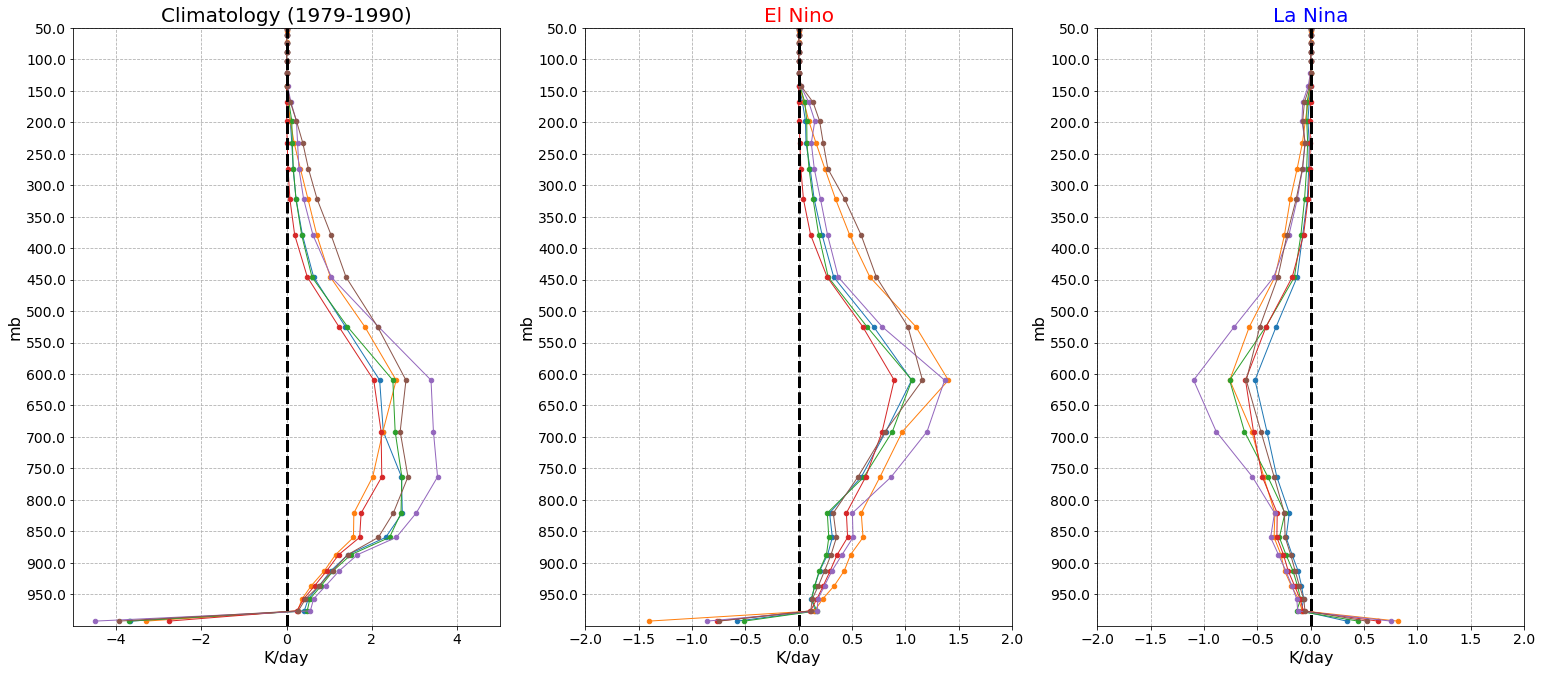

/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/glade/work/rneale/python/miniconda3/envs/neale_myenv/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geome

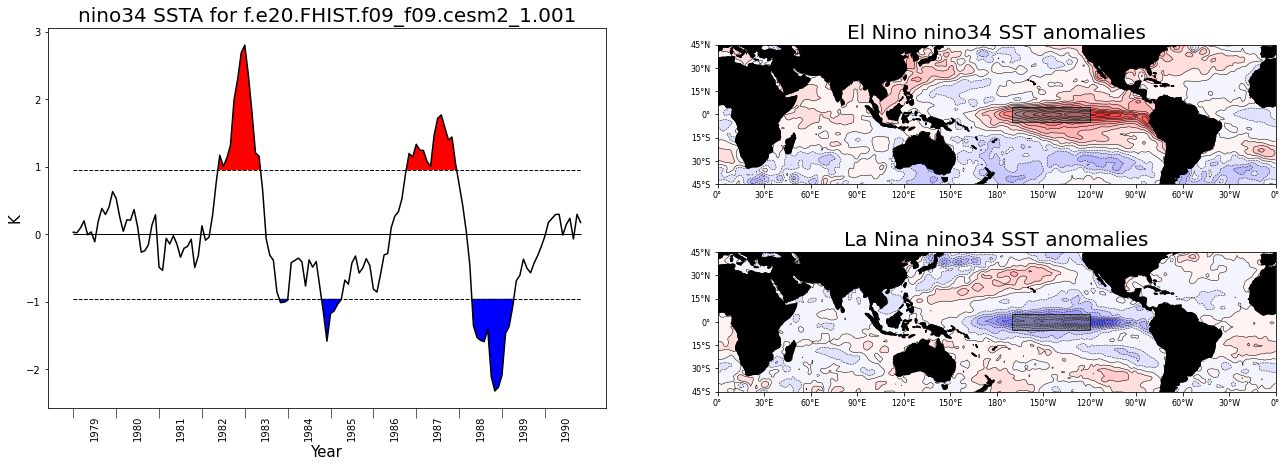

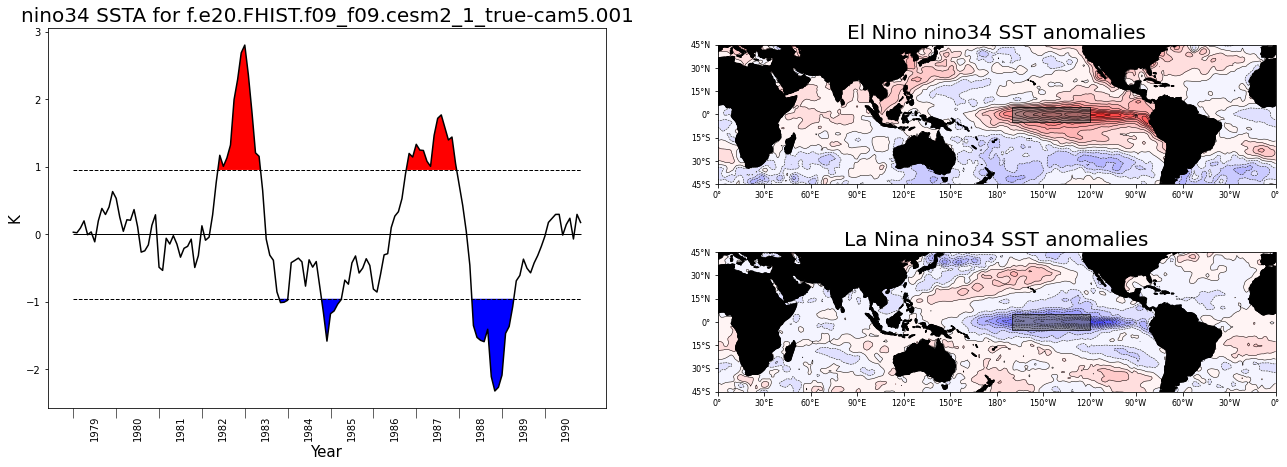

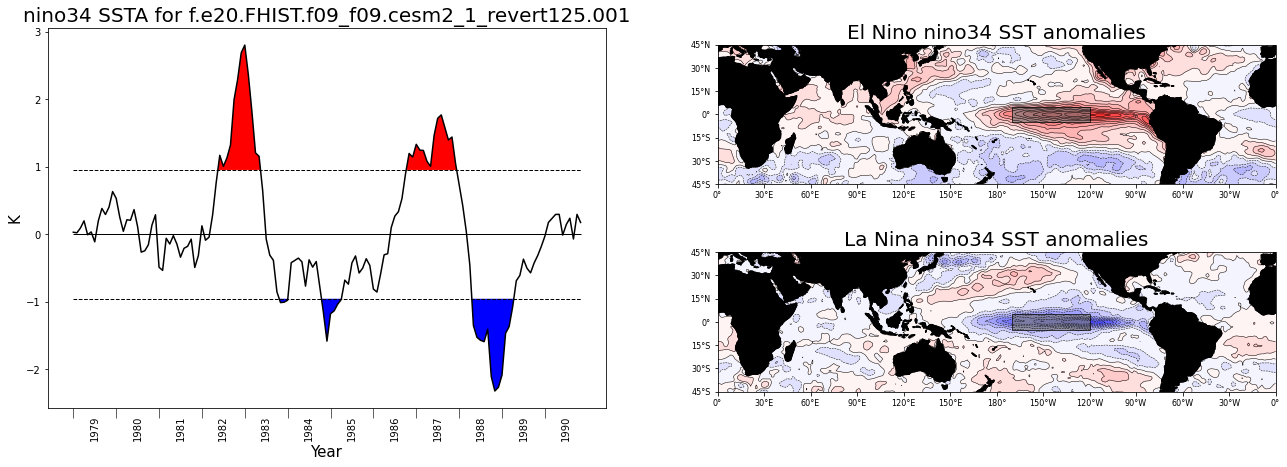

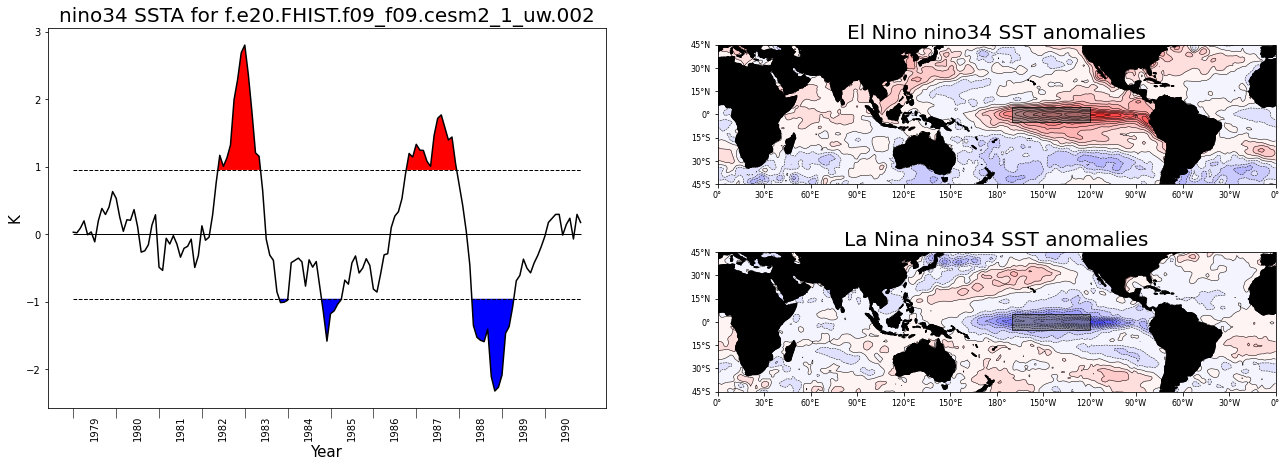

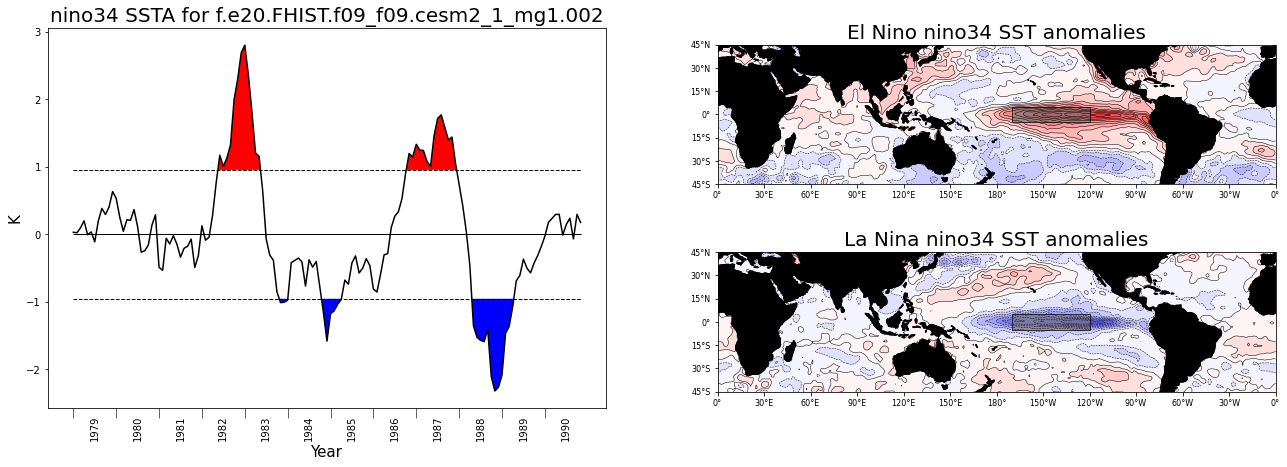

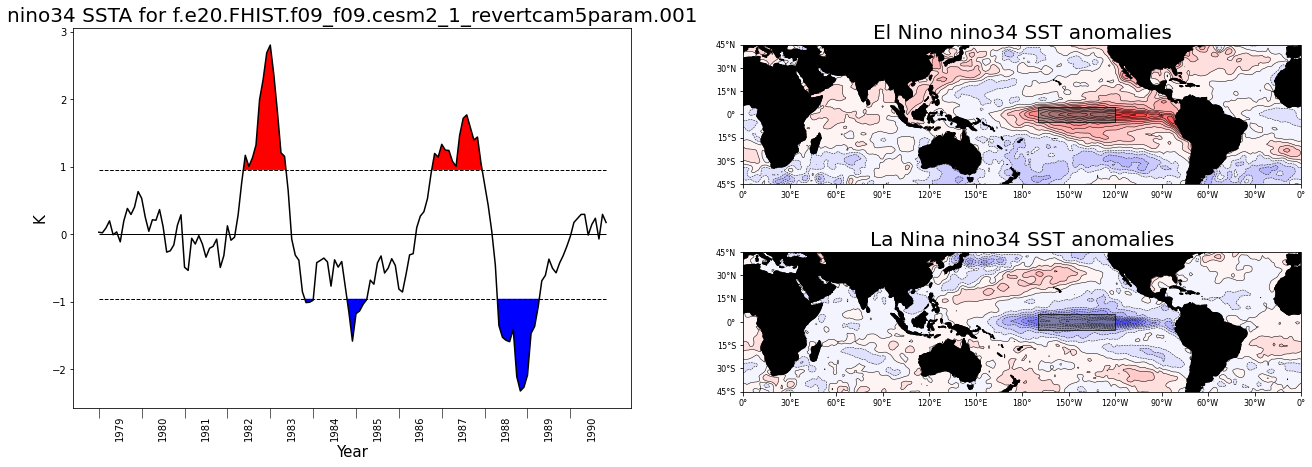

In [5]:
%%time
importlib.reload(mypy) # Required because I am constantly editing scam_func.py
importlib.reload(mycase) # Required because I am constantly editing scam_func.py



# importlib.reload(mypy) # Required because I am constantly editing scam_func.py

### Read in history monthly mean files and composite profiles for tendencies###
dir_hroot = '/glade/p/cgd/amp/amwg/runs/'

#### Read in Data ####

yr0 = years_data[0]
yr1 = years_data[1]

nino_names = ['Climatology ('+str(yr0)+'-'+str(yr1)+')','El Nino','La Nina']




## PLOTTING RESOURCES ##

fign, axn = mp.subplots(1,3,figsize=(26, 11))  
fign.patch.set_facecolor('white') # Sets the plot background outside the data area to be white. Remove to make it transparent.

nino_colors = ['black','red','blue']

















'''
########################
##### LOOP CASES  ######
########################
'''


for icase,case in enumerate(case_desc): # Do first so don't have to do a read mutliple times

# Grab run name 
    
    sim_name = sim_names.loc[case]['run name']
    
    lclimo = True if reanal_climo and case_type[icase] == 'reanal' else False
   
    
    print('')
    print('')
    print('')
    print('**** **** **** **** **** **** **** **** **** ')
    print('**** CASE # ',[icase+1],' OF ',ncases,' ****')
    print('**** **** **** **** **** **** **** **** **** ')
    print('- Name = ',case,' ->',sim_name)
    print('**** **** **** **** **** **** **** **** **** ')
    print('')   
    
    
    ## Read data in from files ##

# Construct required history file month-year array

#    hist_myr = np.array([".cam.h0.%d-%02d.nc"%(y, m) for y in range(yr0,yr1+1) for m in range(1,12+1)])
#    num_h0 = hist_myr.size
  

#    hfile_var = get_files_tseries(run_type,case_type,True) # Grab SST files
 
    print('-- SET TIME RANGE OF TIMESERIES DATA -- ',yr0,' to ',yr1)
    print('-- Grabbing variable files --')
    
    if lclimo:  # Read in tseries based files here for the analysis variable
        files_ptr,var_name   = mypy.get_files_climo(sim_name,case_type[icase],var_cam,years_data) # Grab variable
    else :
        files_ptr,var_name   = mypy.get_files_tseries(sim_name,case_type[icase],var_cam,years_data) # Grab variable
    
    
   
    ## TS FROM HISTORY FILES (just copy for h0 files if they are already read in)
    ## Can still do this for lclimo as it will take observed if reanal

    print('-- Grabbing SST files --')
    if case_type[icase] in ['cam6_revert']: # I think this effectively acts as a pointer, I hope!
        tfiles_ptr = files_ptr 
        tvar_name = 'TS'
    else :   
        tfiles_ptr,tvar_name = mypy.get_files_tseries(sim_name,case_type[icase],'TS',years_data) # Grab TS for nino timeseries


# Have to modify based on month 1 is jan and not feb
#    hfiles_ptr.time.dt.month[0]=1




#    hmonths = hfiles_ptr.time.dt.month    

    ''' TRIM FOR SPECIFIED YEARS '''
    
   
    print('-- Calculating and plotting nino SST anomalies')

 
 

    print(tvar_name,str(yr0),str(yr1))
    sst_data = tfiles_ptr[tvar_name].sel(time=slice(str(yr0), str(yr1)))
    

    
    ''' SST ANOMALY ROUTINE ARRAY '''
  
    sst_months =  sst_data.time.dt.strftime("%b")    
    inino_mons,inina_mons = mypy.nino_sst_anom(sim_name,sst_data,nino_region)
    
    print('-- NINO grab:  Done --')
   
    
    
    
    ''' SUBSET SEASON MONTHS '''
    
#    print(files_ptr[var_name].dt)     
#    date_after_month = date.today()+ relativedelta(months=1)
#    print ('Today: ',date.today().strftime('%d/%m/%Y'))
#    print ('After Month:', dt.strftime('%d/%m/%Y'))

#    dt_index = files_ptr.indexes['time'].to_datetimeindex()
#    print(dt.date.today())
#    print(dt_index.month)
#    print(relativedelta(months=-1))
#    print(dt.date.today()+relativedelta(months=-10))

#    print(dt_index+relativedelta(months=+1))

#    print(dt_index.month)
    
    
#    time = files_ptr.time 
#    print(dt_index)
#    files_ptr['time'] = dt_index 
    
#    hmonths = files_ptr.time.dt.strftime("%b")
 
#    print(files_ptr.time.time)
#    print(pd.to_datetime(files_ptr.time))
    

    

    
 
   
        
# Just read in the season months and levs we need
    
   
    if not lclimo:
        
        ## Need to split what is done fo climo versus tseries here.

        
        var_in = files_ptr[var_name].sel(time=slice(str(yr0),str(yr1)))
        
        
        if case_type[icase] in ['lens1','lens2','c6_amip']:
            print('-- "Compute" the variable array now (bring it up from lazy array) if != ANALYSES')
            %time var_in = var_in.compute()

    # Grab time coord.
        time_in = var_in.time


        ''' Need to Rename Vertical Pressure Coordinate '''




        ''' Trim locations (lat/lev) for simplicity '''


        lev_in = var_in.lev

        ilevs = np.where(lev_in >= min(p_levs))

        ilevs = ilevs[0]
        lev = lev_in[ilevs]


    # Check SST size with Variable size

        if sst_data.time.size != time_in.size : print('SST and VARIABLE sizes DO NOT MATCH - ',sst_data.time.size,' and ',time_in.size) 

        month_nums = time_in.dt.month   
        hmonths = time_in.dt.strftime("%b")



    # Poor man's modifcation for lens1 ts
    #    if case_type[icase] == 'lens1' :
    #            month_nums = month_nums-1 # Set back 1 month
    #            month_nums[month_nums ==-1] = 12 # Set -1 months back to 12
    #    mon_obj = dt.datetime.strptime(mon_nums, "%m")


        lmon_seas = np.isin(hmonths,seas_mons) # Logical for seaon months in all months
        imon_seas = np.argwhere(lmon_seas)[:,0] # Indices
        hmon_seas = hmonths[imon_seas] # Subsetting full months.


    # Seasonal selection for ninos 

    #    lnino_seas = np.isin(hmonths[inino_mons],seas_mons) # Logical for season months in all months
    #    inino_seas= inino_mons[np.argwhere(lnino_seas)[:,0]] # Indices of origin nino_mons that match the season
    #    inino_seas = np.argwhere(lnino_seas)[:,0] # Indices of origin nino_mons that match the season


    #    lnina_seas = np.isin(hmonths[inina_mons],seas_mons) # Logical for season months in all months
    #    inina_seas= inina_mons[np.argwhere(lnina_seas)[:,0]] # Indices of origin nino_mons that match the season
    #    inina_seas= np.argwhere(lnina_seas)[:,0] # Indices of origin nino_mons that match the season   

        var_in = var_in.loc[:,:,reg_s:reg_n,reg_w:reg_e] # Limit the levels

    #  
        var_in = var_in[:,ilevs,:,:]   
        dp_lev = np.diff(lev)



    ## Much easier than above but doing the intersections of months and nino months.
        inino_seas,inino_ind,imon_nino_ind = np.intersect1d(inino_mons, imon_seas, return_indices=True)
        inina_seas,inina_ind,imon_nina_ind = np.intersect1d(inina_mons, imon_seas, return_indices=True)


    ## Could speed up below by reading in var_in for the season months then subsetting that for nino/nina    
    ## Remember: It is reading in a subset of seaonal months and then nino/nina are a subset of those. 

        var_in_inseas = var_df.loc[var_cam]['vscale']*var_in[imon_seas,:,:,:] # Pull only the months we need
      

        if case_type[icase] in ['reanal','cam6_revert']:
            print('-- "Compute" the variable array now (bring it up front lazy array) if == ANALYSES')
            %time var_in_inseas = var_in_inseas.compute()

        var_in_seas = var_in_inseas.mean(dim=['time'])  # Perform seasonal average

        var_in_nino = var_in_inseas[imon_nino_ind,:,:,:].mean(dim=['time'])  # Take nino/nina months from the seasonal timeseries months
        var_in_nina = var_in_inseas[imon_nina_ind,:,:,:].mean(dim=['time']) 

    
    else :    ### Just grab separate data from climo, nino and nina files.
        
        var_in_seas =  files_ptr[var_name].isel(time=0)
        var_in_nino =  files_ptr[var_name].isel(time=1)
        var_in_nina =  files_ptr[var_name].isel(time=2)
        
        
        lev_in = var_in_seas.lev
        ilevs = np.where(lev_in >= min(p_levs))

        lev = lev_in[ilevs]

  
        var_in_seas =  var_df.loc[var_cam]['ovscale']*var_in_seas.loc[lev[0]:lev[-1],reg_s:reg_n,reg_w:reg_e]
        var_in_nino =  var_df.loc[var_cam]['ovscale']*var_in_nino.loc[lev[0]:lev[-1],reg_s:reg_n,reg_w:reg_e]
        var_in_nina =  var_df.loc[var_cam]['ovscale']*var_in_nina.loc[lev[0]:lev[-1],reg_s:reg_n,reg_w:reg_e]

    
## USUAL WAY ##    
    
#    var_in_seas = var_df.loc[var_cam]['vscale']*var_in[imon_seas,:,:,:].mean(dim=['time']) 
#    var_in_nino = var_df.loc[var_cam]['vscale']*var_in[inino_seas,:,:,:].mean(dim=['time']) 
#    var_in_nina = var_df.loc[var_cam]['vscale']*var_in[inina_seas,:,:,:].mean(dim=['time']) 
  






    '''
    ########################    
    ### Now Loop Regions ###
    ########################
    ''' 
    
    for ireg,reg in enumerate(reg_df.index):  ## 4 regions let's assume ##

### Assign lat/lon region domain ###
        print(reg,ireg)
        reg_name = reg_df.loc[reg]['long_name'] 
    
#        reg_s = reg_df.loc[reg]['lat_s'] ; reg_n = reg_df.loc[reg]['lat_n']
#        reg_w = reg_df.loc[reg]['lon_w'] ; reg_e = reg_df.loc[reg]['lon_e']
        
        print()
        print('-- Region = ',reg_name,' - ',reg_s,reg_n,reg_w,reg_e)
                   
        reg_a_str = '%d-%d\u00b0E %.1f-%d\u00b0N' % (reg_w,reg_e,reg_s,reg_n)
        reg_a_out = '%d-%dE_%.1f-%dN' % (reg_w,reg_e,reg_s,reg_n)  
         
        print('-- Averaging for region - ',reg_a_str)

        
        
### Compute Seasonal/El Nino/La Nina profiles
         

    
        varp_seas = var_in_seas.loc[:,reg_s:reg_n,reg_w:reg_e]
        
        if lclimo :
            
            varp_nino = var_in_nino.loc[:,reg_s:reg_n,reg_w:reg_e]
            varp_nina = var_in_nina.loc[:,reg_s:reg_n,reg_w:reg_e]
        
        else :
        
            varp_nino = var_in_nino.loc[:,reg_s:reg_n,reg_w:reg_e]-varp_seas
            varp_nina = var_in_nina.loc[:,reg_s:reg_n,reg_w:reg_e]-varp_seas
        
        varp_all = (varp_seas,varp_nino,varp_nina) # Put in tuple for looping.
               
        
        
        pmark,lcolor,lwidth  = ('x','Black',3)   if case_type[icase] == 'reanal' else   (None,'red',1)  
        if case_type[icase] == 'cam6_revert':
            pmark,lcolor,lwidth = ('.',None,1)
    
              
                           
        '''
        ####################################    
        ### Loop climo/nino/nina periods ###
        ####################################
        '''     
        
## LOOP: Seasonal/El Nino/La Nina plots for this region.
 

        for iplot,var_plot in enumerate(varp_all):
            
            print('    -- Period = '+nino_names[iplot])
            pxmin = xmin if iplot == 0 else axmin
            pxmax = xmax if iplot == 0 else axmax
            
# Regional average
            var_fig = var_plot.mean(dim=['lat','lon'],skipna = True)   
        
        
           
            
            if ldiv and var_cam == 'OMEGA':
                var_fig = var_fig.differentiate("lev")
                
           
            axn[iplot].plot(var_fig,lev,lw=lwidth,markersize=9,marker=pmark,color=lcolor)  
 


            if (icase==0) :
                axn[iplot].set_title(nino_names[iplot],fontsize=20,color=nino_colors[iplot])
                axn[iplot].set_xlim([pxmin,pxmax])
                axn[iplot].set_ylim([ppmax,ppmin])
                axn[iplot].set_ylabel('mb',fontsize=16) 
                axn[iplot].set_xlabel(vunits,fontsize=16)      
                axn[iplot].set_yticks(p_levs)
                axn[iplot].set_yticklabels(p_levs,fontsize=14)
###                axn[iplot].set_xticklabels(np.arange(xmin,xmax,0.1*(xmax-xmin)),fontsize=12)
                axn[iplot].tick_params(axis='both', which='major', labelsize=14)

                axn[iplot].grid(linestyle='--')  
                
    
            if ((pxmin < 0) and (pxmax > 0)) :
                axn[iplot].vlines(0., ppmax, ppmin, linestyle="--",lw=3, color='black')

             
    
# Legend ### Perform a bit of logic for the  
#rtypes, counts = np.unique(case_type, return_counts=True)
#if counts.min == 1:
leg_cases = case_desc

# Don't repeat lens in legend if there are many cases.


if 'lens1' in case_type : 
    leg_cases = [case_desc[0],'lens1']
    if 'reanal' not in case_type :
        leg_cases = ['lens1']
        
if 'lens2' in case_type : 
    leg_cases = [case_type[0],'lens2']
    if 'reanal' not in case_type :
        leg_cases = ['lens2']
        
if 'c6_amip' in case_type : 
    leg_cases = [case_type[0],'c6_amip']
    if 'reanal' not in case_type :
        leg_cases = ['c6_amip']
    

lloc = 'lower right' if var_name in ['ZMDQ','STEND_CLUBB'] else 'lower left' 
axn[0].legend(leg_cases,fontsize=15,loc = lloc)


    # Main title
fign.suptitle('ENSO Anomalies - '+reg_name+' -- '+reg_a_str+' - '+var_text,fontsize=20)

mp.rcParams['xtick.labelsize'] = 15 # Global set of xtick label size    

    
#    mp.show()





# Hard copy  
fign.savefig(dir_proot+pref_out+'_nino_vprof_'+var_pname+'_'+reg_a_out+'_'+str(yr0)+'_to_'+str(yr1)+'.png', dpi=80)

#mp.show()   |

print()
print()
print('-- End Timing --')